# Predicting Gender from Titanic dataset

In [538]:
# Load modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Input, 
                                     Embedding, 
                                     Reshape, 
                                     Concatenate, 
                                     Dense, 
                                     Dropout, 
                                     Flatten)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 1. Load data/ Get basic overview

In [617]:
# load data
file_path = 'C:/Users/alexp/Documents/Study/assignments/data/train.csv'
data = pd.read_csv(file_path, sep = ',')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- Data contains 12 columns of various variables in shapes of numbers and objects or strings.

In [618]:
data.head(10) # check what the columns and their values look like

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


## 2. Data Preprocessing:

In [619]:
# Checking for duplicates in the data
print('Number of duplicates:', data.duplicated().sum())

Number of duplicates: 0


In [620]:
# Checking for NAs in the data
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- Age, Cabin and Embarked include NAs so we need to deal with them. 

#### Fill NAs and make new features if possible

In [621]:
# fill in missing values for 'Age' #with the median age 
data['Age'].fillna(data['Age'].median(), inplace=True) 

# fill in missing values for 'Embarked' #with the most frequently occurring value value
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True) # C = Cherbourg, Q = Queenstown, S = Southampton

# fill missing Cabin values with a placeholder 'Unknown'
data['Cabin'].fillna('Unknown', inplace=True)

# extract the deck information from the Cabin feature (first letter)
data['Deck'] = data['Cabin'].apply(lambda x: x[0] if x != 'Unknown' else 'U')

# make feature HasCabin coded as 1 (True) for each row where Cabin does not equal Unknown else 0 (False)
data['HasCabin'] = (data['Cabin'] != 'Unknown').astype(int)

# make feature 'CabinGroup' and assign a unique integer to each unique value in the 'Cabin' column
data['CabinGroup'] = pd.factorize(data['Cabin'])[0]

# make feature 'FamilySize' from 'SibSp' and 'Parch' (+1 for the passenger themselves)
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1 

# make feature IsAlone coded as 1 (True) for each row where FamilySize equals 1 else 0 (False)
data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

# make feature 'TicketGroup' and assign a unique integer to each unique value in the 'Ticket' column
data['TicketGroup'] = pd.factorize(data['Ticket'])[0]
    
data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Deck           0
HasCabin       0
CabinGroup     0
FamilySize     0
IsAlone        0
TicketGroup    0
dtype: int64

- Successfully removed NAs and created new features out of Cabin, Ticket and columns for spouses, parents.. 
- I would like to treat the Unknowns in the CabinGroup as its own category assuming these people did not have a cabin because they perhaps travelled in too low of a class to have one or shared some kind of large space with other people of lower class

In [622]:
# drop columns we don't need 
data = data.drop(['Name', 'Cabin','Ticket','PassengerId'], axis=1)

In [623]:
data.head(5) # check the newly made features

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,HasCabin,CabinGroup,FamilySize,IsAlone,TicketGroup
0,0,3,male,22.0,1,0,7.2500,S,U,0,0,2,0,0
1,1,1,female,38.0,1,0,71.2833,C,C,1,1,2,0,1
2,1,3,female,26.0,0,0,7.9250,S,U,0,0,1,1,2
3,1,1,female,35.0,1,0,53.1000,S,C,1,2,2,0,3
4,0,3,male,35.0,0,0,8.0500,S,U,0,0,1,1,4


## 3. Exploratory data analysis

In [624]:
# Basic descriptive analysis for features with int or float values
data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,HasCabin,CabinGroup,FamilySize,IsAlone,TicketGroup
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208,0.228956,15.527497,1.904602,0.602694,306.859708
std,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429,0.420397,34.996694,1.613459,0.489615,197.286045
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,1.000000,0.000000,135.000000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000,1.000000,285.000000
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,0.000000,0.000000,2.000000,1.000000,474.500000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,147.000000,11.000000,1.000000,680.000000


In [625]:
# Basic descriptive analysis for categorical features which have string values
data.describe(include=['O'])

,Sex,Embarked,Deck
count,891,891,891
unique,2,3,9
top,male,S,U
freq,577,646,687


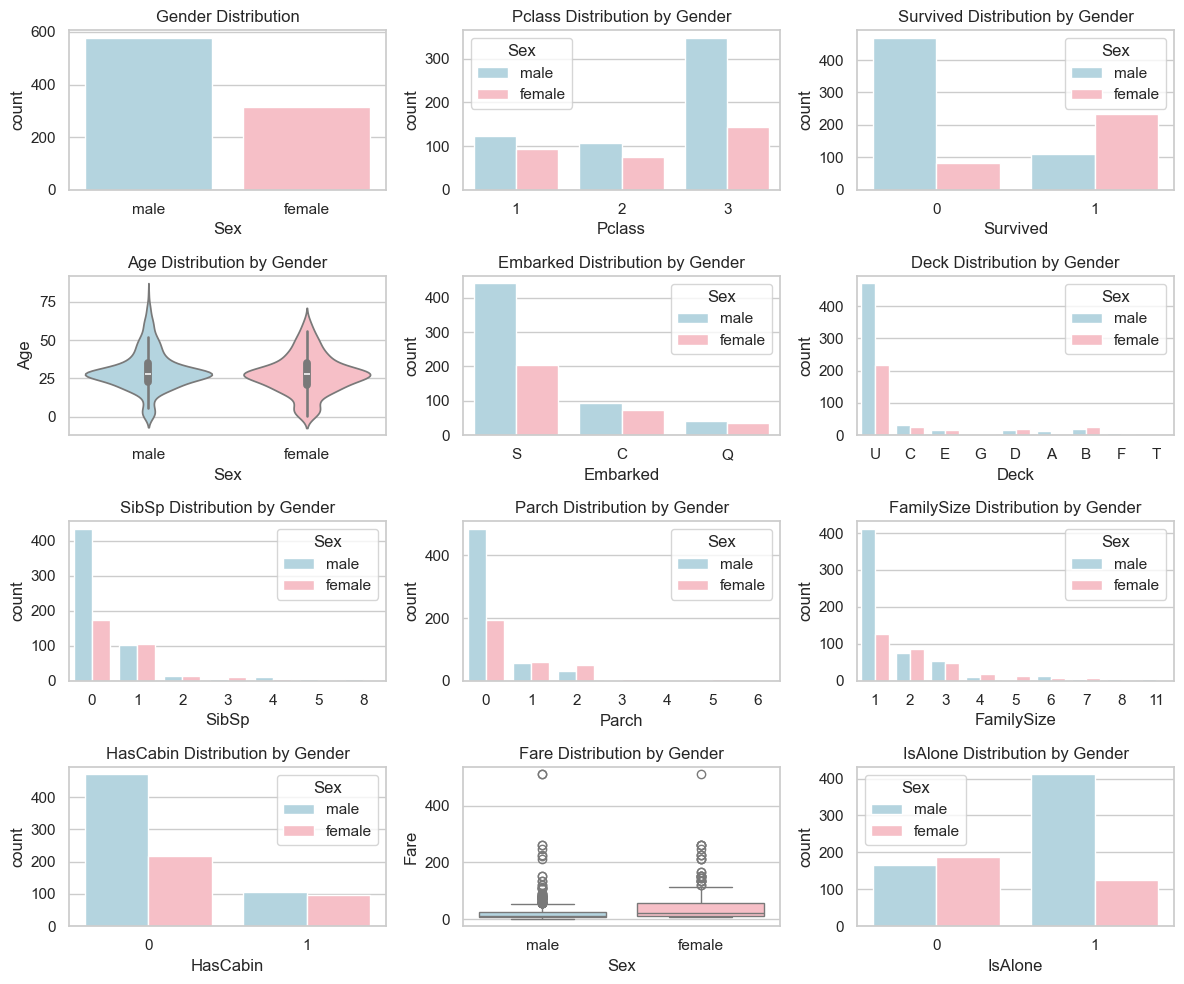

In [581]:
# Make plots in roder to assess how different features are distributed in relation to 'Sex' 
# Define color palette for plots
gender_palette = {'male': '#add8e6', 'female': '#ffb6c1'}

# Set up a 4x3 grid for subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 10))

# Gender distribution
sns.countplot(x='Sex', hue='Sex', data=data, ax=axes[0, 0], order=['male', 'female'], palette=gender_palette, legend=False)
axes[0, 0].set_title('Gender Distribution')

# Pclass Distribution by Gender
sns.countplot(x='Pclass', hue='Sex', data=data, ax=axes[0, 1], hue_order=['male', 'female'], palette=gender_palette)
axes[0, 1].set_title('Pclass Distribution by Gender')

# Survived Distribution by Gender
sns.countplot(x='Survived', hue='Sex', data=data, ax=axes[0, 2], hue_order=['male', 'female'], palette=gender_palette)
axes[0, 2].set_title('Survived Distribution by Gender')

# Age Distribution by Gender using a violin plot
sns.violinplot(x='Sex', y='Age', hue='Sex', data=data, ax=axes[1, 0], palette=gender_palette)
axes[1, 0].set_title('Age Distribution by Gender')

# Embarked Distribution by Gender
sns.countplot(x='Embarked', hue='Sex', data=data, ax=axes[1, 1], hue_order=['male', 'female'], palette=gender_palette)
axes[1, 1].set_title('Embarked Distribution by Gender')

# Deck Distribution by Gender
sns.countplot(x='Deck', hue='Sex', data=data, ax=axes[1, 2], hue_order=['male', 'female'], palette=gender_palette)
axes[1, 2].set_title('Deck Distribution by Gender')

# HasCabin Distribution by Gender
sns.countplot(x='HasCabin', hue='Sex', data=data, ax=axes[3, 0], hue_order=['male', 'female'], palette=gender_palette)
axes[3, 0].set_title('HasCabin Distribution by Gender')

# SibSp Distribution by Gender
sns.countplot(x='SibSp', hue='Sex', data=data, ax=axes[2, 0], hue_order=['male', 'female'], palette=gender_palette)
axes[2, 0].set_title('SibSp Distribution by Gender')

# Parch Distribution by Gender
sns.countplot(x='Parch', hue='Sex', data=data, ax=axes[2, 1], hue_order=['male', 'female'], palette=gender_palette)
axes[2, 1].set_title('Parch Distribution by Gender')

# FamilySize Distribution by Gender
sns.countplot(x='FamilySize', hue='Sex', data=data, ax=axes[2, 2], hue_order=['male', 'female'], palette=gender_palette)
axes[2, 2].set_title('FamilySize Distribution by Gender')

# Fare Distribution by Gender
sns.boxplot(x='Sex', y='Fare', hue='Sex', data=data, ax=axes[3, 1], hue_order=['male', 'female'], palette=gender_palette)
axes[3, 1].set_title('Fare Distribution by Gender')

# IsAlone Distribution by Gender
sns.countplot(x='IsAlone', hue='Sex', data=data, ax=axes[3, 2], hue_order=['male', 'female'], palette=gender_palette)
axes[3, 2].set_title('IsAlone Distribution by Gender')

# Adjust layout
plt.tight_layout()
plt.show()

- Gender Distribution: There are more males than females in the dataset.

- Class Distribution by Gender: More males are in the third class, while first and second classes are more balanced.

- Survival Distribution by Gender: A higher proportion of females survived compared to males.

- Age Distribution by Gender: Both males and females have a similar age distribution, but there are more young males compared to females.

- Embarkation Point Distribution by Gender: Most passengers, regardless of gender, embarked at the 'S' location. Fewer females embarked at 'Q' compared to males.

- Deck Distribution by Gender: The 'U' (possibly representing 'Unknown' or an unnamed deck) has the highest count for both genders, with more males than females. Other decks show varying distributions.

- Family Size Distribution by Gender: Most passengers, regardless of gender, traveled without family or in small families. Very few traveled in large families (greater than 4 members).

- Siblings/Spouses Aboard Distribution by Gender: Most passengers, regardless of gender, had no siblings or spouses aboard. There are more males with no siblings/spouses than females.

- Parents/Children Aboard Distribution by Gender: Similar to the siblings/spouses distribution, most traveled without parents or children, with more males in this category.

- Cabin Possession Distribution by Gender: More males did not have a cabin compared to females.

- Fare Distribution by Gender: There's a wide range of fares paid by passengers, with some extreme outliers, especially in the male distribution. It might be beneficial to opt for RobustScaler later on so we can still include these observations in the analysis as they can represent the top of the socioeconomic classes of the time. 

- IsAlone Distribution by Gender: More males travelled alone compared to females. More females travelled with their family, than alone. 

## Correlation with 'sex' plot

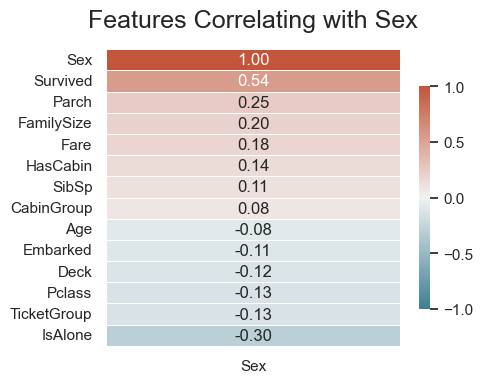

In [626]:
# make a copy of the original DataFrame so we can manipulate values for purpose of the plot
data_corrplot = data.copy()

# male = 0, female = 1
data_corrplot['Sex'] = data_corrplot['Sex'].apply(lambda x: 1 if x == 'female' else 0)

# convert the 'Deck' and 'Embarked' features to numeric using Label Encoding
for feature in ['Deck', 'Embarked']:
    encoder = LabelEncoder()
    data_corrplot[feature] = encoder.fit_transform(data_corrplot[feature])
    
# calculate correlation and select only the 'Sex' column
correlation_with_sex = data_corrplot.corr()[['Sex']]

# set up the figure
plt.figure(figsize=(5, 4))

# color palette
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# create a heatmap
heatmap = sns.heatmap(
    correlation_with_sex.sort_values(by='Sex', ascending=False),
    vmin=-1, vmax=1,
    annot=True,
    fmt=".2f",  # format annotations to two decimal places
    cmap=cmap,
    linewidths=.5,  # add linewidth between cells
    cbar_kws={"shrink": 0.75},  # adjust color bar size
)

# set title and adjust layout
heatmap.set_title('Features Correlating with Sex', fontdict={'fontsize': 18}, pad=16)

# show the plot
plt.tight_layout()
plt.show()

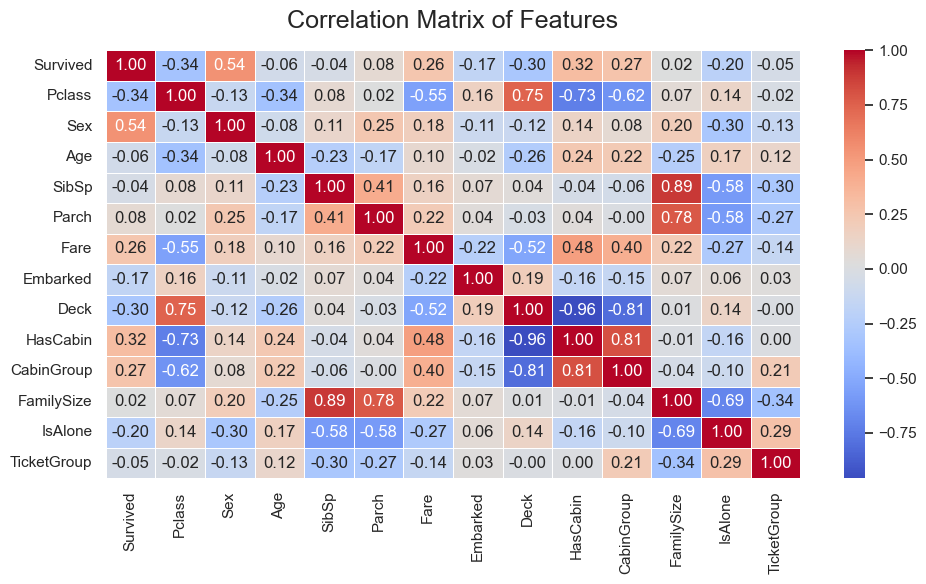

In [583]:
# correlation matrix for all features in dataset
correlation_matrix = data_corrplot.corr()

# set up the figure
plt.figure(figsize=(10, 6))

# create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)

# set title and adjust layout
plt.title('Correlation Matrix of Features', fontdict={'fontsize': 18}, pad=16)

# show the plot
plt.tight_layout()
plt.show()

- Feture correlation matrix can help us decide on which features to choose for our model. If some features are highly correlated we could exclude one from the analysis if it seems to be a weaker predictor and keep the one that shows more distinct pattern in relation to gender. 

## 4. Decision Trees Classifier

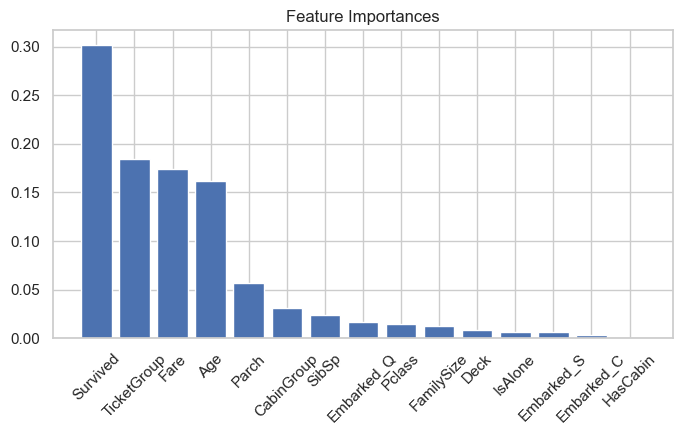

In [641]:
# divide data into features X and target y
X = data.drop(['Sex'], axis=1)
y = data['Sex'].apply(lambda x: 1 if x == 'female' else 0) # manually encode male as 0, female as 1

# convert categorical variables into numerical ones for the model
# get_dummies for 'Embarked' as there is no ordinal relationship 
X = pd.get_dummies(X, columns=['Embarked'],dtype=int)

# convert the 'Pclass', 'Deck','CabinGroup','TicketGroup' features using Label Encoding
for feature in ['Pclass', 'Deck','CabinGroup','TicketGroup' ]:
    encoder = LabelEncoder()
    X[feature] = encoder.fit_transform(X[feature])
    

# normalize the numerical features
scaler = StandardScaler()
X[['Age', 'Fare']] = scaler.fit_transform(X[['Age', 'Fare']])

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# decision Tree model
dt_classifier = DecisionTreeClassifier(random_state=42)

# train classifier
dt_classifier.fit(X_train, y_train)

# access feature importances
importances = dt_classifier.feature_importances_

# sort feature importances in descending order
indices = importances.argsort()[::-1]

# plot the feature importances 
plt.figure(figsize=(8, 4))
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)
plt.title("Feature Importances")
plt.show()

In [642]:
# make predictions on testing data
y_pred = dt_classifier.predict(X_test)

# compare predictions of y('Sex') with actual y labels and print accuracy
dt_accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {dt_accuracy}")

Decision Tree Accuracy: 0.7206703910614525


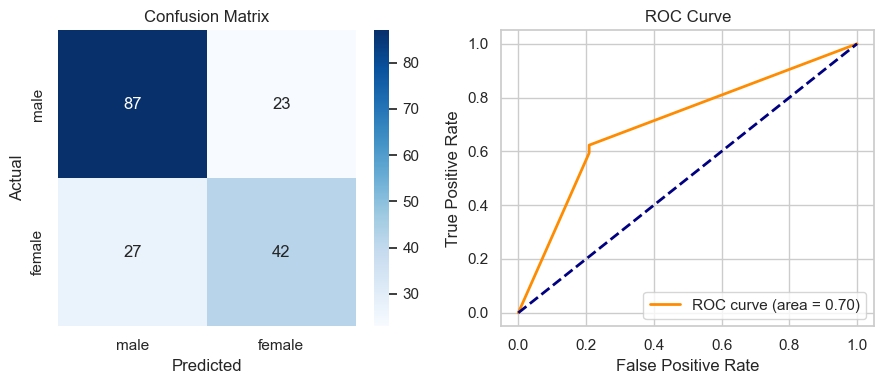

In [647]:
# create confusion matrix plot, ROC curve plot to better assess model performance
# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))

# plot confusion matrix
plt.figure(figsize=(9, 4))

# subplot for Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['male', 'female'], yticklabels=['male', 'female'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

# subplot for ROC Curve
plt.subplot(1, 2, 2)

# ROC Curve and AUC-ROC
y_prob = dt_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# plot ROC Curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [631]:
# classification report
classifier_metrics = classification_report(y_test, y_pred)
print("Classification Report:\n", classifier_metrics)

# cross-validation
cv_scores = cross_val_score(dt_classifier, X, y, cv=5)  # 5-fold cross-validation
print("Cross-Validation Scores:", cv_scores)

# mean accuracy and standard deviation for cross-validation
mean_accuracy = np.mean(cv_scores)
std_accuracy = np.std(cv_scores)

print(f"Mean Accuracy: {mean_accuracy:.2%}")
print(f"Standard Deviation: {std_accuracy:.2%}")

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.79      0.78       110
           1       0.65      0.61      0.63        69

    accuracy                           0.72       179
   macro avg       0.70      0.70      0.70       179
weighted avg       0.72      0.72      0.72       179

Cross-Validation Scores: [0.70949721 0.69662921 0.66292135 0.74719101 0.75280899]
Mean Accuracy: 71.38%
Standard Deviation: 3.33%


- We aim for the cross-validation scores to be consistent and not vary too much between folds. Mean accuracy of 71.38% is a decent performance. A standard deviation of 3.33% indicates a moderate amount of variability in the performance but it's not excessively high. Overall, the model achieves reasonably consistent performance but we could definitely improve it by tweaking the features. We could exclude features which seem less significant in gender prediction as seen above on the feature importance plot.

## 5. NN with embeddings for each categorical feature

In [648]:
# convert categorical variables into numerical ones for the model
# identifying numerical and categorical features
numerical_features = ['Age', 'SibSp', 'Parch','Fare','FamilySize'] 
categorical_features = ['Survived','Pclass','Embarked','Deck','HasCabin','CabinGroup','TicketGroup','IsAlone']

# divide the data into features X and target y
X = data.drop(['Sex'], axis=1)
y = data['Sex'].apply(lambda x: 1 if x == 'female' else 0)

# convert the 'Pclass', 'Deck','Embarked' features using Label Encoding
for feature in ['Pclass', 'Deck','Embarked']:
    encoder = LabelEncoder()
    X[feature] = encoder.fit_transform(X[feature])

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# separate categorical and numeric features
cat_features_train = X_train[categorical_features]
num_features_train = X_train[numerical_features]

cat_features_test = X_test[categorical_features]
num_features_test = X_test[numerical_features]

# standardize numeric features
scaler = StandardScaler()
num_features_train = scaler.fit_transform(num_features_train)
num_features_test = scaler.transform(num_features_test)

# define embedding_dim
embedding_dim = 5

# create empty lists to hold inputs and embeddings
embedding_layers = []
input_layers = []

# dictionary to hold the number of unique values for each categorical feature
unique_values_dict = {
    'Survived': 2, # max value is 1 so we set 2 and so on      
    'Pclass': 3,        
    'Embarked': 3,      
    'Deck': 9,          
    'HasCabin': 2,     
    'CabinGroup': 148,  
    'TicketGroup': 681, 
    'IsAlone': 2
}

# loop over categorical features
for col in categorical_features:
    # retrieve the number of unique values for this feature
    unique_values = unique_values_dict[col]

    # create an input layer for each categorical feature
    input_layer = Input(shape=(1,), name=f"{col}_input")
    input_layers.append(input_layer)

    # create an embedding layer for each categorical feature
    embedding_layer = Embedding(input_dim=unique_values, output_dim=embedding_dim, input_length=1)(input_layer)
    embedding_layers.append(embedding_layer)

# concatenate all the embeddings
concatenated = Concatenate()(embedding_layers)

# flatten the concatenated embeddings
flatten = Flatten()(concatenated)

# ddd dense layers for numerical features
numerical_input = Input(shape=(num_features_train.shape[1],), name="numerical_input")
dense1 = Dense(units=64, activation='relu')(numerical_input)
dropout = Dropout(0.5)(dense1)
dense2 = Dense(units=32, activation='relu')(dropout)

# concatenate the flattened embeddings with the dense layer output
merged = Concatenate()([flatten, dense2])

# define output layer
output_layer = Dense(units=1, activation='sigmoid')(merged)

# create the final model
model = Model(inputs=input_layers + [numerical_input], outputs=output_layer)

# initial learning rate
initial_learning_rate = 0.001

# define the learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

# create an optimizer with the learning rate schedule
optimizer = Adam(learning_rate=lr_schedule)

# compile the model and print the summary
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_78"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Survived_input (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 Pclass_input (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 Embarked_input (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                           

In [649]:
# define early stopping and model checkpoints 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

mc = ModelCheckpoint("best_model",
                      monitor="val_accuracy",
                      verbose=1,
                      save_best_only=True,
                      save_weights_only=False,
                      mode='max',
                      save_freq="epoch")

# train the nn
history = model.fit([X_train[col].values for col in categorical_features] + [num_features_train], y_train, 
                    epochs=50, 
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[es,mc])

# make predictions
y_pred_prob = model.predict([X_test[col].values for col in categorical_features] + [num_features_test])
y_pred = (y_pred_prob > 0.5).astype('int32')

# evaluate the model
test_loss, test_accuracy = model.evaluate([X_test[col].values for col in categorical_features] + [num_features_test], y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/50
14/18 [======================>.......] - ETA: 0s - loss: 0.6736 - accuracy: 0.6205 
Epoch 1: val_accuracy improved from -inf to 0.66434, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


18/18 [==============================] - 9s 347ms/step - loss: 0.6675 - accuracy: 0.6292 - val_loss: 0.6415 - val_accuracy: 0.6643
Epoch 2/50
17/18 [===========================>..] - ETA: 0s - loss: 0.6278 - accuracy: 0.6581
Epoch 2: val_accuracy improved from 0.66434 to 0.67832, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


18/18 [==============================] - 2s 103ms/step - loss: 0.6249 - accuracy: 0.6626 - val_loss: 0.6106 - val_accuracy: 0.6783
Epoch 3/50
 1/18 [>.............................] - ETA: 0s - loss: 0.6911 - accuracy: 0.4688
Epoch 3: val_accuracy did not improve from 0.67832
18/18 [==============================] - 0s 5ms/step - loss: 0.6005 - accuracy: 0.6854 - val_loss: 0.5928 - val_accuracy: 0.6783
Epoch 4/50
 1/18 [>.............................] - ETA: 0s - loss: 0.4545 - accuracy: 0.8125
Epoch 4: val_accuracy improved from 0.67832 to 0.68531, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


18/18 [==============================] - 1s 79ms/step - loss: 0.5813 - accuracy: 0.6837 - val_loss: 0.5826 - val_accuracy: 0.6853
Epoch 5/50
17/18 [===========================>..] - ETA: 0s - loss: 0.5653 - accuracy: 0.7040
Epoch 5: val_accuracy did not improve from 0.68531
18/18 [==============================] - 0s 6ms/step - loss: 0.5679 - accuracy: 0.7047 - val_loss: 0.5751 - val_accuracy: 0.6853
Epoch 6/50
17/18 [===========================>..] - ETA: 0s - loss: 0.5552 - accuracy: 0.7151
Epoch 6: val_accuracy improved from 0.68531 to 0.69930, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


18/18 [==============================] - 1s 80ms/step - loss: 0.5583 - accuracy: 0.7100 - val_loss: 0.5663 - val_accuracy: 0.6993
Epoch 7/50
18/18 [==============================] - ETA: 0s - loss: 0.5491 - accuracy: 0.7293
Epoch 7: val_accuracy improved from 0.69930 to 0.71329, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


18/18 [==============================] - 1s 78ms/step - loss: 0.5491 - accuracy: 0.7293 - val_loss: 0.5571 - val_accuracy: 0.7133
Epoch 8/50
 1/18 [>.............................] - ETA: 0s - loss: 0.5536 - accuracy: 0.7500
Epoch 8: val_accuracy improved from 0.71329 to 0.72028, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


18/18 [==============================] - 1s 78ms/step - loss: 0.5295 - accuracy: 0.7346 - val_loss: 0.5474 - val_accuracy: 0.7203
Epoch 9/50
 1/18 [>.............................] - ETA: 0s - loss: 0.4450 - accuracy: 0.8125
Epoch 9: val_accuracy did not improve from 0.72028
18/18 [==============================] - 0s 6ms/step - loss: 0.5227 - accuracy: 0.7592 - val_loss: 0.5365 - val_accuracy: 0.7203
Epoch 10/50
16/18 [=========================>....] - ETA: 0s - loss: 0.5164 - accuracy: 0.7598
Epoch 10: val_accuracy did not improve from 0.72028
18/18 [==============================] - 0s 6ms/step - loss: 0.5174 - accuracy: 0.7610 - val_loss: 0.5262 - val_accuracy: 0.7203
Epoch 11/50
 1/18 [>.............................] - ETA: 0s - loss: 0.4832 - accuracy: 0.8125
Epoch 11: val_accuracy did not improve from 0.72028
18/18 [==============================] - 0s 6ms/step - loss: 0.4950 - accuracy: 0.7750 - val_loss: 0.5165 - val_accuracy: 0.7203
Epoch 12/50
17/18 [=========================

INFO:tensorflow:Assets written to: best_model\assets


18/18 [==============================] - 1s 83ms/step - loss: 0.4774 - accuracy: 0.7891 - val_loss: 0.5080 - val_accuracy: 0.7273
Epoch 13/50
14/18 [======================>.......] - ETA: 0s - loss: 0.4593 - accuracy: 0.8013
Epoch 13: val_accuracy improved from 0.72727 to 0.74126, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


18/18 [==============================] - 2s 94ms/step - loss: 0.4699 - accuracy: 0.7979 - val_loss: 0.4984 - val_accuracy: 0.7413
Epoch 14/50
16/18 [=========================>....] - ETA: 0s - loss: 0.4478 - accuracy: 0.7910
Epoch 14: val_accuracy improved from 0.74126 to 0.75524, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


18/18 [==============================] - 2s 95ms/step - loss: 0.4524 - accuracy: 0.7891 - val_loss: 0.4902 - val_accuracy: 0.7552
Epoch 15/50
18/18 [==============================] - ETA: 0s - loss: 0.4400 - accuracy: 0.8049
Epoch 15: val_accuracy did not improve from 0.75524
18/18 [==============================] - 0s 6ms/step - loss: 0.4400 - accuracy: 0.8049 - val_loss: 0.4846 - val_accuracy: 0.7552
Epoch 16/50
15/18 [========================>.....] - ETA: 0s - loss: 0.4289 - accuracy: 0.8229
Epoch 16: val_accuracy improved from 0.75524 to 0.76224, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


18/18 [==============================] - 2s 100ms/step - loss: 0.4293 - accuracy: 0.8243 - val_loss: 0.4776 - val_accuracy: 0.7622
Epoch 17/50
 1/18 [>.............................] - ETA: 0s - loss: 0.4272 - accuracy: 0.8438
Epoch 17: val_accuracy did not improve from 0.76224
18/18 [==============================] - 0s 7ms/step - loss: 0.4101 - accuracy: 0.8330 - val_loss: 0.4734 - val_accuracy: 0.7622
Epoch 18/50
 1/18 [>.............................] - ETA: 0s - loss: 0.4824 - accuracy: 0.7812
Epoch 18: val_accuracy did not improve from 0.76224
18/18 [==============================] - 0s 5ms/step - loss: 0.4049 - accuracy: 0.8418 - val_loss: 0.4686 - val_accuracy: 0.7622
Epoch 19/50
 1/18 [>.............................] - ETA: 0s - loss: 0.4745 - accuracy: 0.7500
Epoch 19: val_accuracy improved from 0.76224 to 0.77622, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


18/18 [==============================] - 2s 93ms/step - loss: 0.3925 - accuracy: 0.8471 - val_loss: 0.4640 - val_accuracy: 0.7762
Epoch 20/50
 1/18 [>.............................] - ETA: 0s - loss: 0.3760 - accuracy: 0.8438
Epoch 20: val_accuracy improved from 0.77622 to 0.78322, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


18/18 [==============================] - 2s 99ms/step - loss: 0.3863 - accuracy: 0.8453 - val_loss: 0.4603 - val_accuracy: 0.7832
Epoch 21/50
14/18 [======================>.......] - ETA: 0s - loss: 0.3815 - accuracy: 0.8594
Epoch 21: val_accuracy did not improve from 0.78322
18/18 [==============================] - 0s 7ms/step - loss: 0.3748 - accuracy: 0.8647 - val_loss: 0.4589 - val_accuracy: 0.7832
Epoch 22/50
17/18 [===========================>..] - ETA: 0s - loss: 0.3609 - accuracy: 0.8768
Epoch 22: val_accuracy improved from 0.78322 to 0.79021, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


18/18 [==============================] - 2s 103ms/step - loss: 0.3670 - accuracy: 0.8735 - val_loss: 0.4558 - val_accuracy: 0.7902
Epoch 23/50
17/18 [===========================>..] - ETA: 0s - loss: 0.3501 - accuracy: 0.8695
Epoch 23: val_accuracy did not improve from 0.79021
18/18 [==============================] - 0s 7ms/step - loss: 0.3565 - accuracy: 0.8682 - val_loss: 0.4546 - val_accuracy: 0.7902
Epoch 24/50
17/18 [===========================>..] - ETA: 0s - loss: 0.3503 - accuracy: 0.8824
Epoch 24: val_accuracy improved from 0.79021 to 0.80420, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


18/18 [==============================] - 2s 105ms/step - loss: 0.3432 - accuracy: 0.8875 - val_loss: 0.4513 - val_accuracy: 0.8042
Epoch 25/50
17/18 [===========================>..] - ETA: 0s - loss: 0.3414 - accuracy: 0.8768
Epoch 25: val_accuracy did not improve from 0.80420
18/18 [==============================] - 0s 6ms/step - loss: 0.3363 - accuracy: 0.8805 - val_loss: 0.4517 - val_accuracy: 0.8042
Epoch 26/50
17/18 [===========================>..] - ETA: 0s - loss: 0.3183 - accuracy: 0.8860
Epoch 26: val_accuracy improved from 0.80420 to 0.81818, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


18/18 [==============================] - 2s 124ms/step - loss: 0.3218 - accuracy: 0.8840 - val_loss: 0.4518 - val_accuracy: 0.8182
Epoch 27/50
13/18 [====================>.........] - ETA: 0s - loss: 0.3093 - accuracy: 0.8918
Epoch 27: val_accuracy did not improve from 0.81818
18/18 [==============================] - 0s 9ms/step - loss: 0.3183 - accuracy: 0.8875 - val_loss: 0.4509 - val_accuracy: 0.8182
Epoch 28/50
13/18 [====================>.........] - ETA: 0s - loss: 0.3142 - accuracy: 0.8846
Epoch 28: val_accuracy did not improve from 0.81818
18/18 [==============================] - 0s 9ms/step - loss: 0.3074 - accuracy: 0.8875 - val_loss: 0.4522 - val_accuracy: 0.8112
Epoch 29/50
14/18 [======================>.......] - ETA: 0s - loss: 0.2993 - accuracy: 0.8862
Epoch 29: val_accuracy did not improve from 0.81818
18/18 [==============================] - 0s 8ms/step - loss: 0.2988 - accuracy: 0.8875 - val_loss: 0.4532 - val_accuracy: 0.8112
Epoch 30/50
11/18 [=================>....

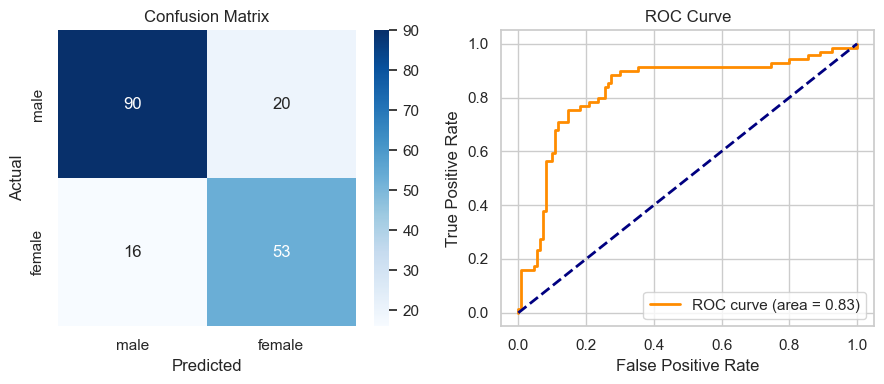

In [652]:
# create confusion matrix plot, ROC curve plot to better assess model performance
# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))

# plot confusion matrix
plt.figure(figsize=(9, 4))

# subplot for Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['male', 'female'], yticklabels=['male', 'female'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

# subplot for ROC Curve
plt.subplot(1, 2, 2)

# ROC Curve and AUC-ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# plot ROC Curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

- The model seems to be better at classifying males. 
- An AUC of 0.83 suggests that the model has good discriminative ability.

In [655]:
# classification report
classifier_metrics = classification_report(y_test, y_pred)
print("Classification Report:\n", classifier_metrics)

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.82      0.83       110
           1       0.73      0.77      0.75        69

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



- The model accurately predicts 80% of the instances, which is quite a decent performance. It is slightly better at predicting class 0 (male). 
- Since the precision, recall, and F1-scores are relatively close together for both classes, it suggests that the model has learned to generalize well and isn’t overly biased towards one class.

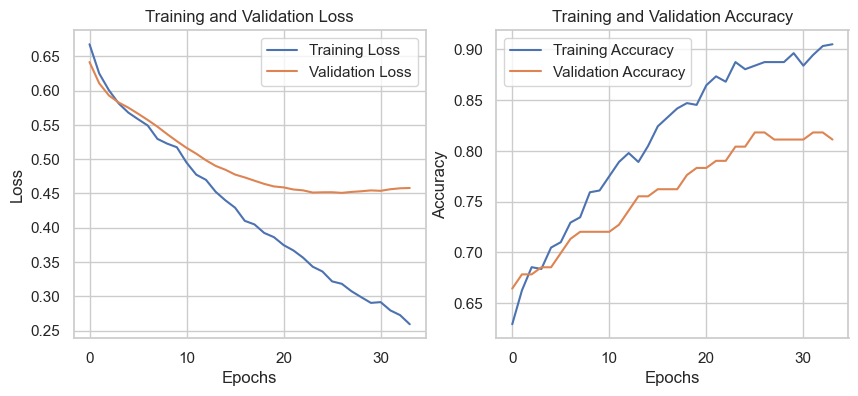

In [653]:
# call model output
history_dict = history.history

# loss curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy curves
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- Early stopping intervened during the 34th epoch of evaluation.
- The training loss decreases consistently suggesting the model is learning from the training data well. 
- The training accuracy increases whihc means the model continues to learn and fit the training data better. 
- While the validation loss initially decreased, it later plateaued and triggered early stopping when a rise was observed, potentially signaling overfitting to the training data.
- The validation accuracy climbs along the training accuracy curve but at a slower rate and starts to pleateau indicating the model is not improving further on validation data. This and the gap between training and validation accuracy curves could suggest overfitting. 

- We could further improve the model performance by implementing GridSearch or RandomSearch in order to find the best hyperparameters for our model. Possible params to search could be embedding_dim, dense_units of layers, dropout_rate, learning_rate, batch_size and epochs.
- We could also implement L1/L2 regularization and K-Fold Cross-Validation